In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [8]:
import glob

BASE_DIR = "./dataset/"
CSV_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")

# Find all images inside "image_001/images/" to "image_012/images/"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
IMAGE_FILES = {os.path.basename(f): f for f in glob.glob(os.path.join(IMAGE_DIR, "*.png"))}

# Check if images were found
print(f"Total images found: {len(IMAGE_FILES)}")

Total images found: 112120


In [10]:
# Filter dataset to keep only images with the specified labels
desired_labels = ['Pneumonia', 'Cardiomegaly', 'Edema', 'Emphysema', 'Effusion', 'Infiltration', 'Atelectasis']
df_filtered = df[df['Finding Labels'].apply(lambda x: any(label in desired_labels for label in x))]

# Convert labels to binary or categorical as needed
df_filtered = df_filtered.copy()  # Prevents modifying a slice
df_filtered['Label'] = df_filtered['Finding Labels'].apply(
    lambda x: [label for label in x if label in desired_labels]
)

# Check label distribution
print(df_filtered['Label'].explode().value_counts())

df_filtered.head()


Label
Infiltration    19894
Effusion        13317
Atelectasis     11559
Cardiomegaly     2776
Emphysema        2516
Edema            2303
Pneumonia        1431
Name: count, dtype: int64


,Image Index,Finding Labels,Label
0,00000001_000.png,[Cardiomegaly],[Cardiomegaly]
1,00000001_001.png,"[Cardiomegaly, Emphysema]","[Cardiomegaly, Emphysema]"
2,00000001_002.png,"[Cardiomegaly, Effusion]","[Cardiomegaly, Effusion]"
7,00000003_003.png,"[Hernia, Infiltration]",[Infiltration]
19,00000005_006.png,[Infiltration],[Infiltration]


In [11]:
unique_labels = set(label for sublist in df_filtered['Finding Labels'] for label in sublist)
print(unique_labels)  # Check what labels exist in df_filtered

{'Hernia', 'Effusion', 'Emphysema', 'Pneumonia', 'Fibrosis', 'Edema', 'Cardiomegaly', 'Nodule', 'Consolidation', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Mass', 'Infiltration'}


In [12]:
print(df[df['Finding Labels'].apply(lambda x: 'Pneumonia' in x)].head(20))

           Image Index                                     Finding Labels
48    00000013_010.png                [Effusion, Pneumonia, Pneumothorax]
126   00000032_012.png     [Atelectasis, Consolidation, Edema, Pneumonia]
253   00000056_000.png                                [Nodule, Pneumonia]
276   00000061_012.png  [Edema, Effusion, Infiltration, Pleural_Thicke...
279   00000061_015.png                                        [Pneumonia]
590   00000144_001.png                                        [Pneumonia]
614   00000150_002.png             [Atelectasis, Infiltration, Pneumonia]
640   00000165_001.png                                        [Pneumonia]
804   00000193_019.png                                        [Pneumonia]
859   00000211_013.png  [Cardiomegaly, Edema, Effusion, Infiltration, ...
864   00000211_018.png                [Cardiomegaly, Effusion, Pneumonia]
901   00000218_000.png                          [Infiltration, Pneumonia]
902   00000218_001.png                

In [13]:
print(df_filtered['Label'].value_counts())

Label
[Infiltration]                                             12438
[Effusion]                                                  6086
[Atelectasis]                                               5707
[Effusion, Infiltration]                                    2271
[Atelectasis, Infiltration]                                 1795
                                                           ...  
[Atelectasis, Edema, Effusion, Emphysema, Infiltration]        1
[Edema, Emphysema, Infiltration]                               1
[Effusion, Emphysema, Infiltration, Pneumonia]                 1
[Effusion, Cardiomegaly]                                       1
[Infiltration, Cardiomegaly]                                   1
Name: count, Length: 92, dtype: int64


In [15]:
X = df_filtered['Image Index'].values
y = df_filtered['Label'].values  # Binary labels

# Train-Test Split (80% Train, 20% Test)
# Flatten the labels to ensure stratification works correctly
y_flat = [label[0] if isinstance(label, list) and len(label) > 0 else label for label in y]

X_train, X_test, y_train, y_test = train_test_split(X, y_flat, test_size=0.2, stratify=y_flat, random_state=42)

# Further split 10% of train set into validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 28493, Validation: 3166, Test: 7915


In [ ]:
# Load CSV and keep only relevant columns
df = pd.read_csv(CSV_PATH)
df = df[['Image Index', 'Finding Labels']]

# Convert multi-labels into lists
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Filter for the specified labels
desired_labels = ['Pneumonia', 'Cardiomegaly', 'Edema', 'Emphysema', 'Effusion', 'Infiltration', 'Atelectasis']
df_filtered = df[df['Finding Labels'].apply(lambda x: any(label in desired_labels for label in x))]

df_filtered = df_filtered.copy()  # Make a copy before modifying

df_filtered.loc[:, 'Label'] = df_filtered['Finding Labels'].apply(
    lambda x: [label for label in x if label in desired_labels]
)
df_filtered.loc[:, 'filename'] = df_filtered['Image Index'].map(IMAGE_FILES)

# Remove missing files
df_filtered = df_filtered.dropna()

print(f"Images available after filtering: {len(df_filtered)}")
df_filtered.head()


Images available after filtering: 39574


,Image Index,Finding Labels,Label,filename
0,00000001_000.png,[Cardiomegaly],[Cardiomegaly],./dataset/images\00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]","[Cardiomegaly, Emphysema]",./dataset/images\00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]","[Cardiomegaly, Effusion]",./dataset/images\00000001_002.png
7,00000003_003.png,"[Hernia, Infiltration]",[Infiltration],./dataset/images\00000003_003.png
19,00000005_006.png,[Infiltration],[Infiltration],./dataset/images\00000005_006.png


In [28]:
train_df, test_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['Label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Label'], random_state=42)

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

# Image augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                   shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from updated file paths
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',  # Full image paths already set in filename column
    y_col='Label',
    directory=None,  # No need for a directory since filenames are absolute paths
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename', 
    y_col='Label',
    directory=None,  # Same fix
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename', 
    y_col='Label',
    directory=None,  # Same fix
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary', 
    shuffle=False
)



ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [18]:
# Load pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [19]:
EPOCHS = 10  # Start small, increase if necessary

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
177/177 [==============================] - 148s 788ms/step - loss: 0.6859 - accuracy: 0.5986 - val_loss: 0.6665 - val_accuracy: 0.6338
Epoch 2/10
177/177 [==============================] - 95s 536ms/step - loss: 0.6630 - accuracy: 0.6237 - val_loss: 0.6604 - val_accuracy: 0.6338
Epoch 3/10
177/177 [==============================] - 96s 539ms/step - loss: 0.6631 - accuracy: 0.6290 - val_loss: 0.6575 - val_accuracy: 0.6338
Epoch 4/10
177/177 [==============================] - 96s 538ms/step - loss: 0.6597 - accuracy: 0.6336 - val_loss: 0.6612 - val_accuracy: 0.6338
Epoch 5/10
177/177 [==============================] - 95s 534ms/step - loss: 0.6621 - accuracy: 0.6354 - val_loss: 0.6572 - val_accuracy: 0.6338
Epoch 6/10
177/177 [==============================] - 94s 532ms/step - loss: 0.6591 - accuracy: 0.6354 - val_loss: 0.6573 - val_accuracy: 0.6338
Epoch 7/10
177/177 [==============================] - 95s 535ms/step - loss: 0.6600 - accuracy: 0.6354 - val_loss: 0.6576 - val_a

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 510ms/step - accuracy: 0.6624 - loss: 0.6192
Test Accuracy: 0.6650


1/1 [==============================] - 0s 51ms/step


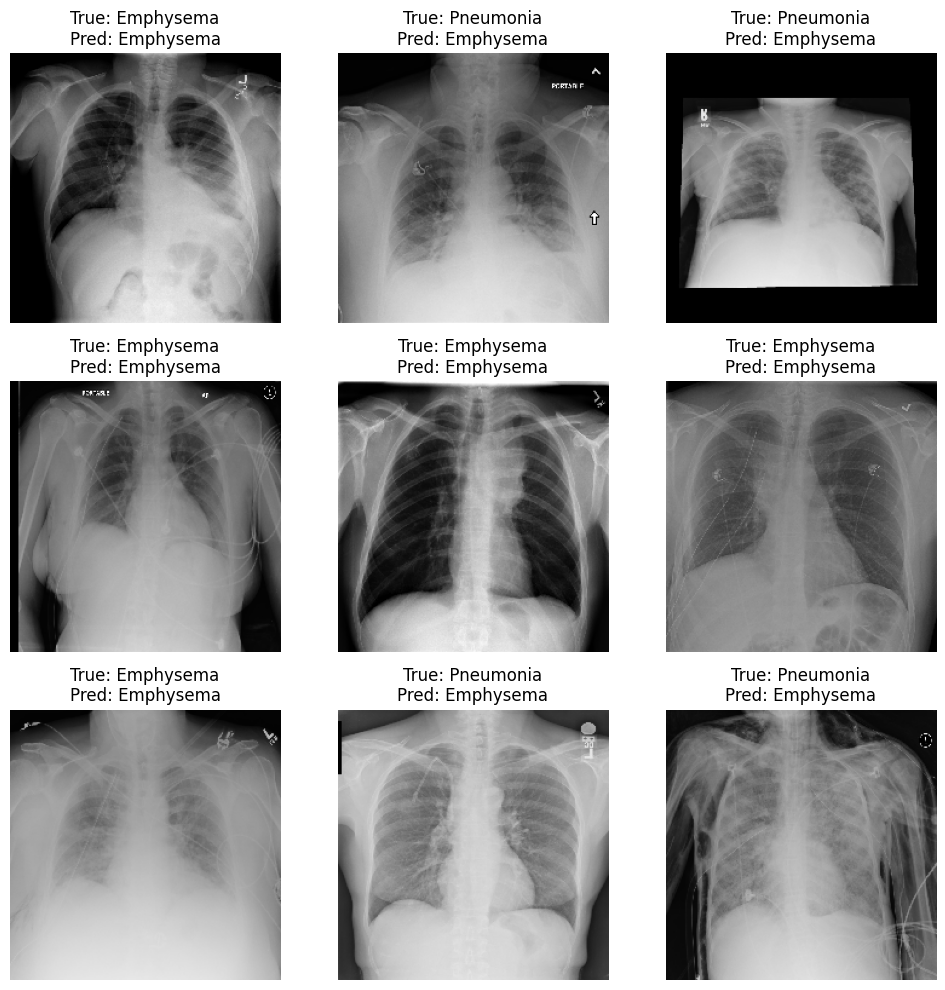

In [25]:
import random

# Select random test images
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)

# Plot images with predictions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    img = sample_images[i]
    true_label = "Pneumonia" if sample_labels[i] == 1 else "Emphysema"
    predicted_label = "Pneumonia" if predictions[i] > 0.5 else "Emphysema"

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
